In [9]:

import os
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [4]:
# Path to extracted folder containing patient data files
data_dir = '/Users/sandhyasrinivasan/clinical-readmission-prediction/data/diabetes/Diabetes-Data'

# Code field mappings
code_map = {
    '33': 'reg_insulin',
    '34': 'nph_insulin',
    '35': 'ultralente_insulin',
    '48': 'glucose_unspecified_1',
    '57': 'glucose_unspecified_2',
    '58': 'glucose_pre_breakfast',
    '59': 'glucose_post_breakfast',
    '60': 'glucose_pre_lunch',
    '61': 'glucose_post_lunch',
    '62': 'glucose_pre_supper',
    '63': 'glucose_post_supper',
    '64': 'glucose_pre_snack',
    '65': 'hypoglycemia',
    '66': 'typical_meal',
    '67': 'high_meal',
    '68': 'low_meal',
    '69': 'typical_exercise',
    '70': 'high_exercise',
    '71': 'low_exercise',
    '72': 'special_event'
}

patient_data = []

for filename in sorted(os.listdir(data_dir)):
    if filename.startswith("data-") and filename[5:].isdigit():
        filepath = os.path.join(data_dir, filename)

        # Parse events from the file
        events = []
        with open(filepath, 'r') as f:
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) == 4:
                    data, time, code, value = parts
                    events.append({'code': code, 'value': value})

    
        # Initialize summary
        patient_summary = {'patient_id': filename}
        glucose_values = []
        insulin_count = 0
        hypo_event_count = 0
        meal_events = 0
        exercise_events = 0

        for event in events:
            code = event['code']
            value = event['value']

            name = code_map.get(code, f"code_{code}")

            # Glucose values
            if 'glucose' in name:
                try:
                    glucose_values.append(float(value))
                except ValueError:
                    continue
            # Insulin count
            if 'insulin' in name:
                insulin_count += 1
            # Hypoglycemia
            if code == '65':
                hypo_event_count += 1
            # Meal
            if code in ['66', '67', '68']:
                meal_events += 1
            # Exercise
            if code in ['69', '70', '71']:
                exercise_events += 1

        # Add summary features
        patient_summary['avg_glucose'] = round(sum(glucose_values)/len(glucose_values), 2) if glucose_values else None
        patient_summary['glucose_readings'] = len(glucose_values)
        patient_summary['insulin_doses'] = insulin_count
        patient_summary['hypo_events'] = hypo_event_count
        patient_summary['meal_events'] = meal_events
        patient_summary['exercise_events'] = exercise_events
        patient_summary['total_events'] = len(events)

        patient_data.append(patient_summary)

# Build DataFrame
df = pd.DataFrame(patient_data)
df.head()

,patient_id,avg_glucose,glucose_readings,insulin_doses,hypo_events,meal_events,exercise_events,total_events
0,data-01,159.05,369,523,51,0,0,943
1,data-02,194.17,373,381,0,0,0,761
2,data-03,134.36,139,134,3,10,0,300
3,data-04,161.01,141,145,1,6,0,300
4,data-05,166.19,144,148,0,2,0,300


## K-Means Clustering

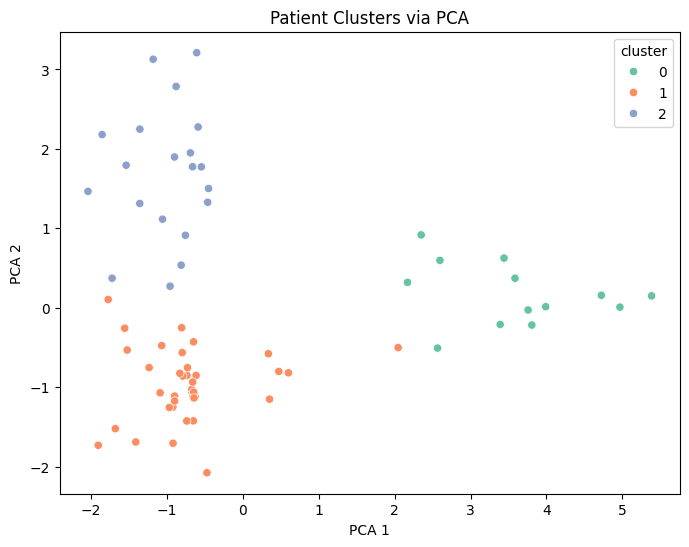

In [12]:
# Drop non-relevant columns
X = df.drop(columns=['patient_id'])

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KMeans algorithm
kmeans = KMeans(n_clusters=3, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# PCA for 2D plot
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df['cluster'], palette='Set2')
plt.title("Patient Clusters via PCA")
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.show()